<a href="https://colab.research.google.com/github/Lois-Lanctot/student-performance-analysis/blob/main/student_performance_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# df = pd.read_csv("/content/student_data.csv") # 0 missing values / small dataset
# df = pd.read_csv("/content/StudentPerformanceFactors.csv") # some missing values
df = pd.read_csv("/content/exams.csv") # 0 missing values
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group D,some college,standard,completed,59,70,78
1,male,group D,associate's degree,standard,none,96,93,87
2,female,group D,some college,free/reduced,none,57,76,77
3,male,group B,some college,free/reduced,none,70,70,63
4,female,group D,associate's degree,standard,none,83,85,86


In [6]:
# df.info()
print("Columns: ", df.columns)
print("Record Count: ", len(df))

Columns:  Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')
Record Count:  1000


In [7]:
print(df.isnull().sum())

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


In [11]:
print(df['gender'].unique())
print(df['race/ethnicity'].unique())
print(df['parental level of education'].unique())
print(df['lunch'].unique())
print(df['test preparation course'].unique())


['female' 'male']
['group D' 'group B' 'group C' 'group E' 'group A']
['some college' "associate's degree" 'some high school'
 "bachelor's degree" "master's degree" 'high school']
['standard' 'free/reduced']
['completed' 'none']


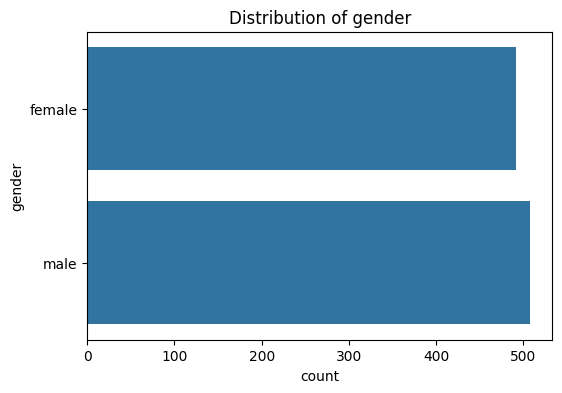

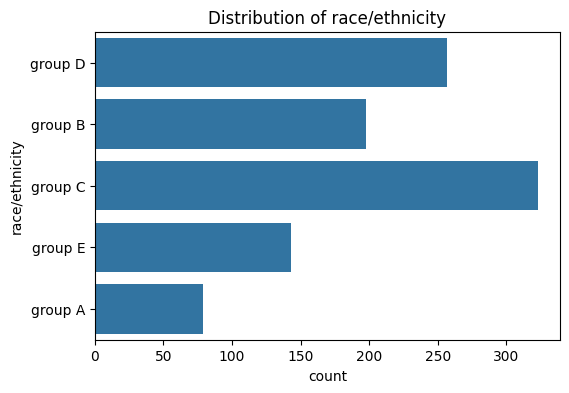

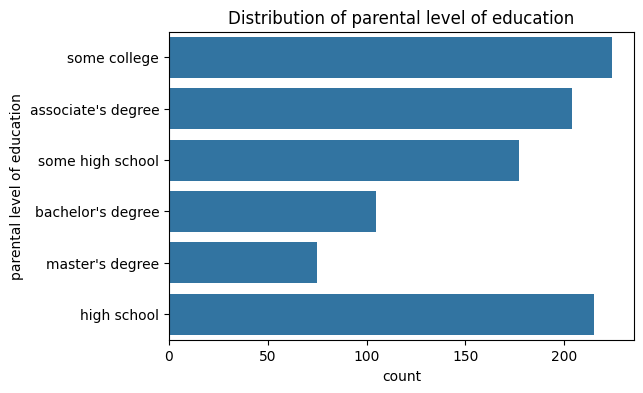

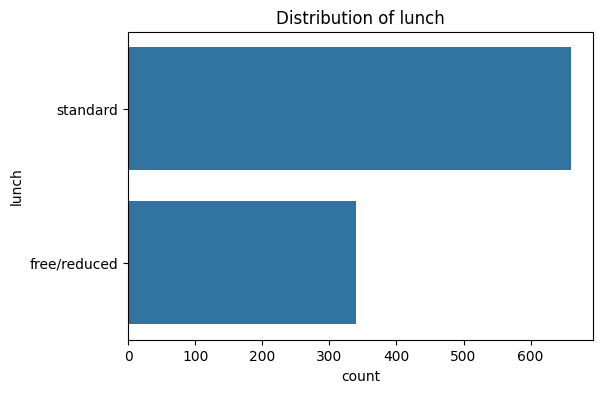

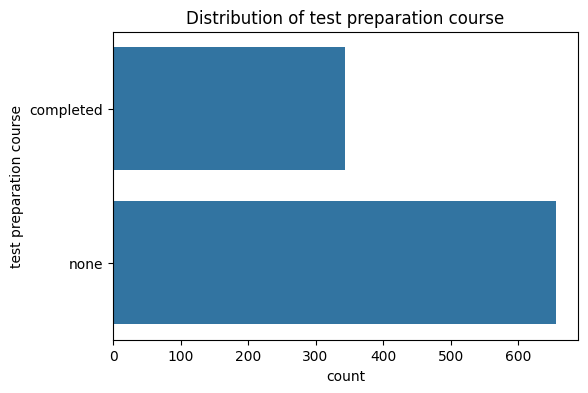

In [13]:
categorical_cols = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(df[col])
    plt.title(f'Distribution of {col}')
    plt.show()


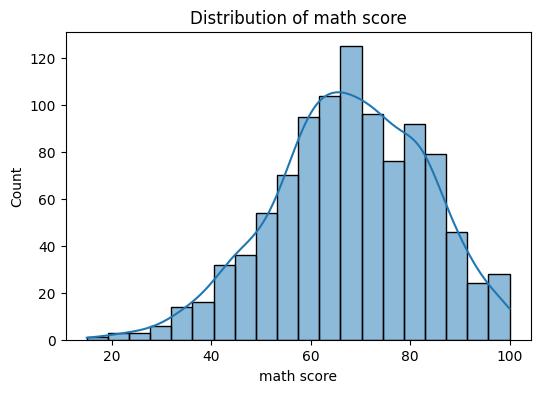

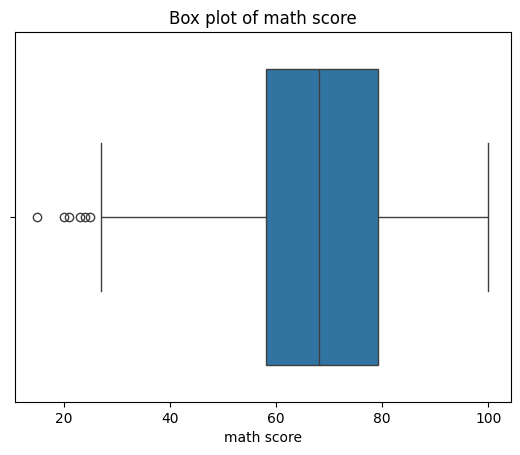

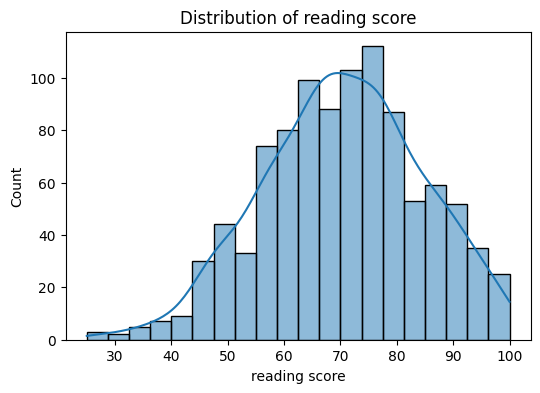

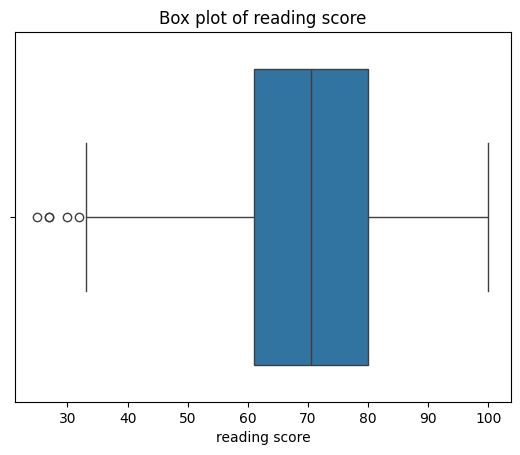

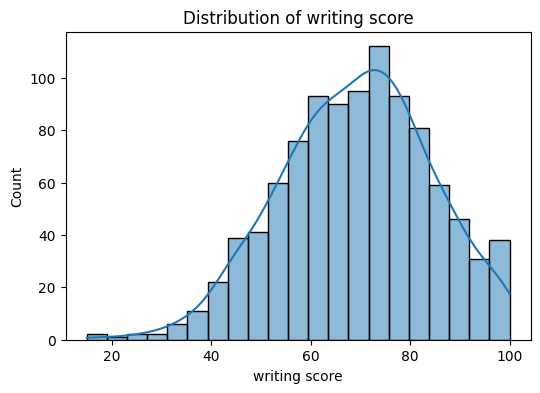

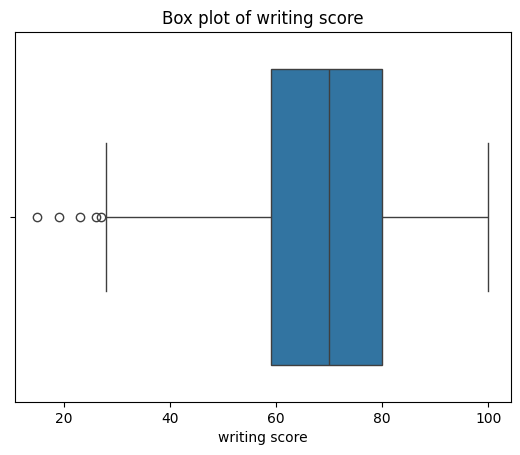

In [15]:
numerical_cols = ['math score', 'reading score', 'writing score']
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

    sns.boxplot(x=df[col])
    plt.title(f'Box plot of {col}')
    plt.show()


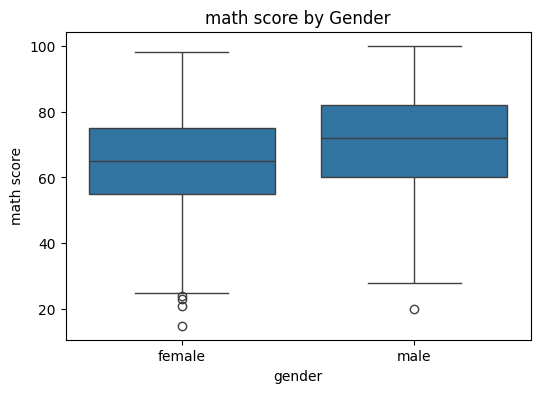

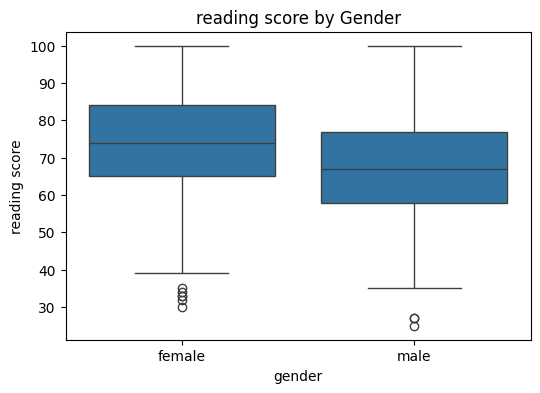

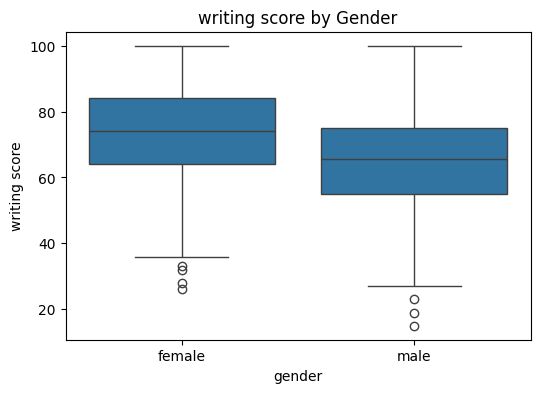

In [19]:
# analyze the relationship between gender and scores
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='gender', y=col, data=df)
    plt.title(f'{col} by Gender')
    plt.show()


In [ ]:
# analyze the relationship between race and scores
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='race/ethnicity', y=col, data=df)
    plt.title(f'{col} by Race/Ethnicity')
    plt.show()


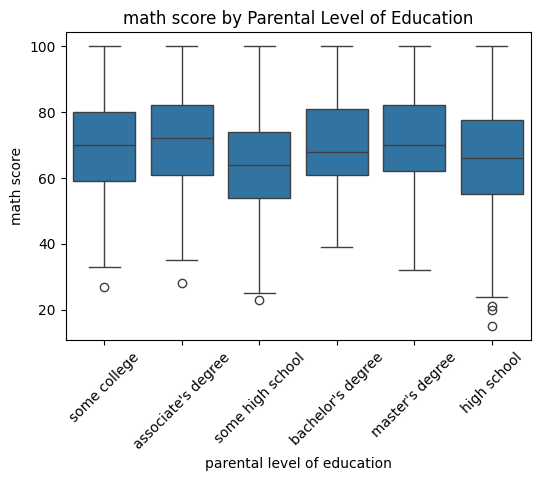

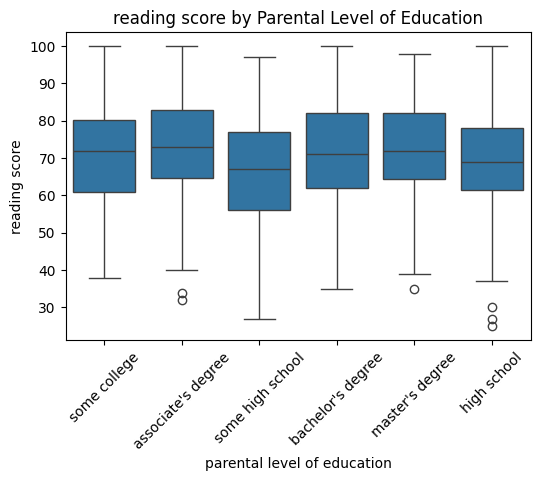

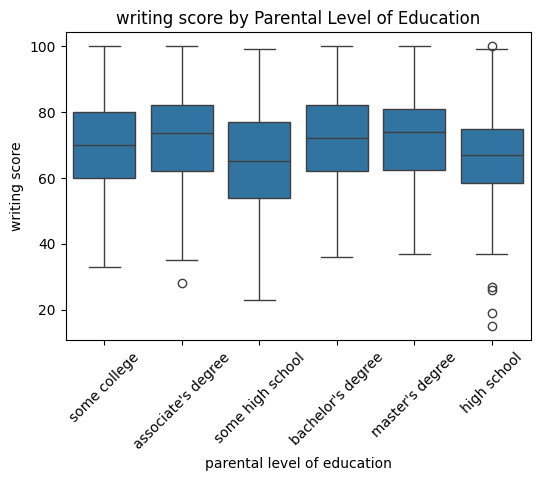

In [21]:
# analyze the relationship between parental education and scores
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='parental level of education', y=col, data=df)
    plt.xticks(rotation=45)
    plt.title(f'{col} by Parental Level of Education')
    plt.show()


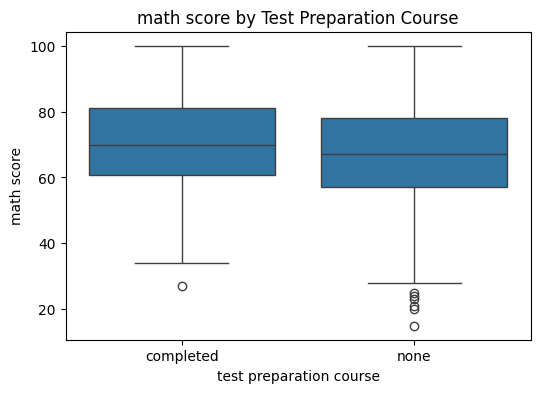

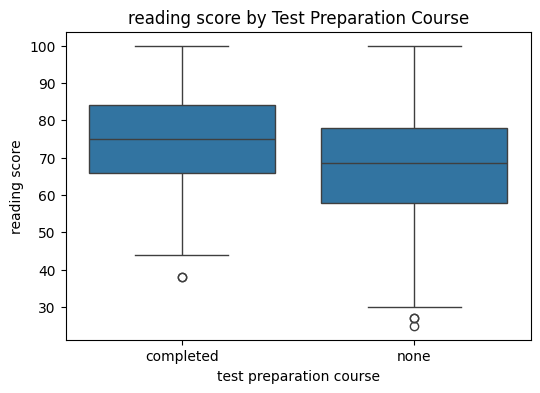

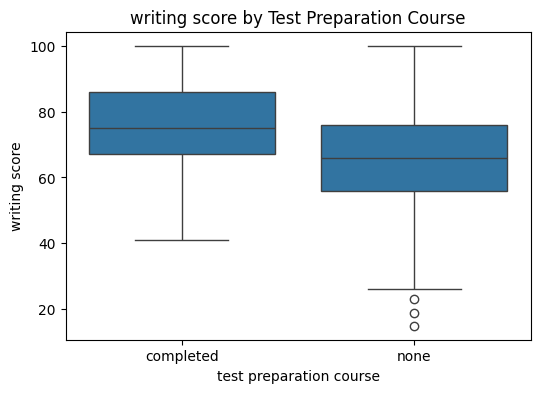

In [22]:
# analyze the relationship between test preparation course completion and scores
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='test preparation course', y=col, data=df)
    plt.title(f'{col} by Test Preparation Course')
    plt.show()


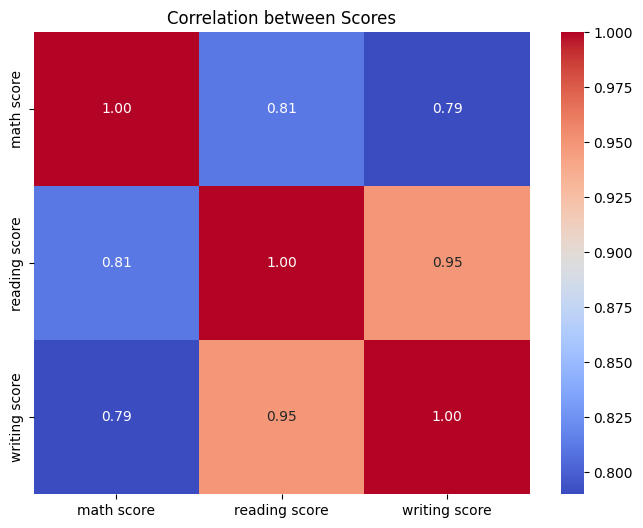

In [24]:
# Correlation heatmap between scores
plt.figure(figsize=(8, 6))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation between Scores')
plt.show()
